In [2]:
import numpy as np
from scipy.stats import chi2
import pandas as pd
#from plot_helpers import *
from operator import itemgetter
from scipy.stats import invwishart, invgamma
import matplotlib.pyplot as plt
from matplotlib import axes
import random
import math
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import time

In [3]:
def confidence_ellipse_mean_cov(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the standard deviation of x from
    # the square root of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', show_scatter=False, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean = np.array([mean_x, mean_y])
    cov = np.cov(x, y)
    #print(mean)
    #print(cov)

    if show_scatter:
        scat_color = "k" #darken_color(facecolor, 0.5)
        ax.plot(x, y, ls='', marker='.', markersize=1, color=scat_color)

    return confidence_ellipse_mean_cov(mean, cov, ax, n_std=n_std, facecolor=facecolor, **kwargs)



## posterior function:

def params_init(data,mu_0,psi_0,kappa_0):
    mu_0 = np.array(mu_0) ## random initialization of mu_s for two distribution
    mean_data = (np.mean(data, axis = 0))
    #psi_0 = (np.eye(mu_0.shape[0])*10).T
    inv_psi_0 = np.linalg.inv(psi_0)
    dim = mu_0.shape[0]
    nu_0 = dim + 2
    n = data.shape[0]
    
    sum_square_0 = np.sum(np.square(data['X_0']-mean_data[0]))
    sum_square_1 = np.sum(np.square(data['X_1']-mean_data[1]))
    
    sum_squares = np.array([sum_square_0,sum_square_1])
    mu_n = np.array(((kappa_0 * mu_0) + (n * mean_data)) / (kappa_0 + n))
    kappa_n = kappa_0 + n
    nu_n = nu_0 + n
    psi_n = psi_0 + sum_squares + kappa_0 * n / float(kappa_0 + n) * np.array(np.matrix(mean_data - mu_0).T * np.matrix(mean_data - mu_0))
    
    params_dict = {"sum_squares":sum_squares, "mu_n":mu_n, "kappa_n": kappa_n, "nu_n": nu_n, "psi_n": psi_n}
    return(params_dict)
    
    ##sum_squares = np.sum([np.array(np.matrix(x - mu_0).T * np.matrix(x - mu_0)) for x in data], axis=0)
    
    
def model(data,mu_n,kappa_n,nu_n,psi_n):
    #psi_n =  np.array([[2000,0],[0,2000]])
    #nu_n = 6
    sigma =  invwishart.rvs(nu_n, psi_n, size=1, random_state=None)
    mu = np.random.multivariate_normal(np.array(mu_n),np.matrix(sigma/kappa_n))
    X_p = np.random.multivariate_normal(mu,sigma)
    return({'sigma':sigma, 'mu':mu, 'X_p':X_p})

def model_iter(data,mu_0,kappa_0,psi_0,iter):
    
    params_dict = params_init(data,mu_0,psi_0,kappa_0)
    sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)
    
    mu_list = []
    X_list = []
    sigma_list = []

    for i in range(iter):
        model_i = model(data,mu_n,kappa_n,nu_n,psi_n)
        sigma_i, mu_i, X_pi = itemgetter('sigma','mu','X_p')(model_i)
        
        mu_list.append(mu_i)
        X_list.append(X_pi)
        sigma_list.append(sigma_i)
        
    return({'mu_list':mu_list, 'X_list':X_list, 'sigma_list':sigma_list})



         X_0       X_1
0   5.793229 -2.807927
1   7.846328 -3.805364
2   3.456800 -2.539429
3  11.261957  0.386806
4   4.777512 -5.547125
[9 0]
prior data mean: ( 15 , -4 )
true mean: ( 6.62716511949157 , -2.862607975738988 )


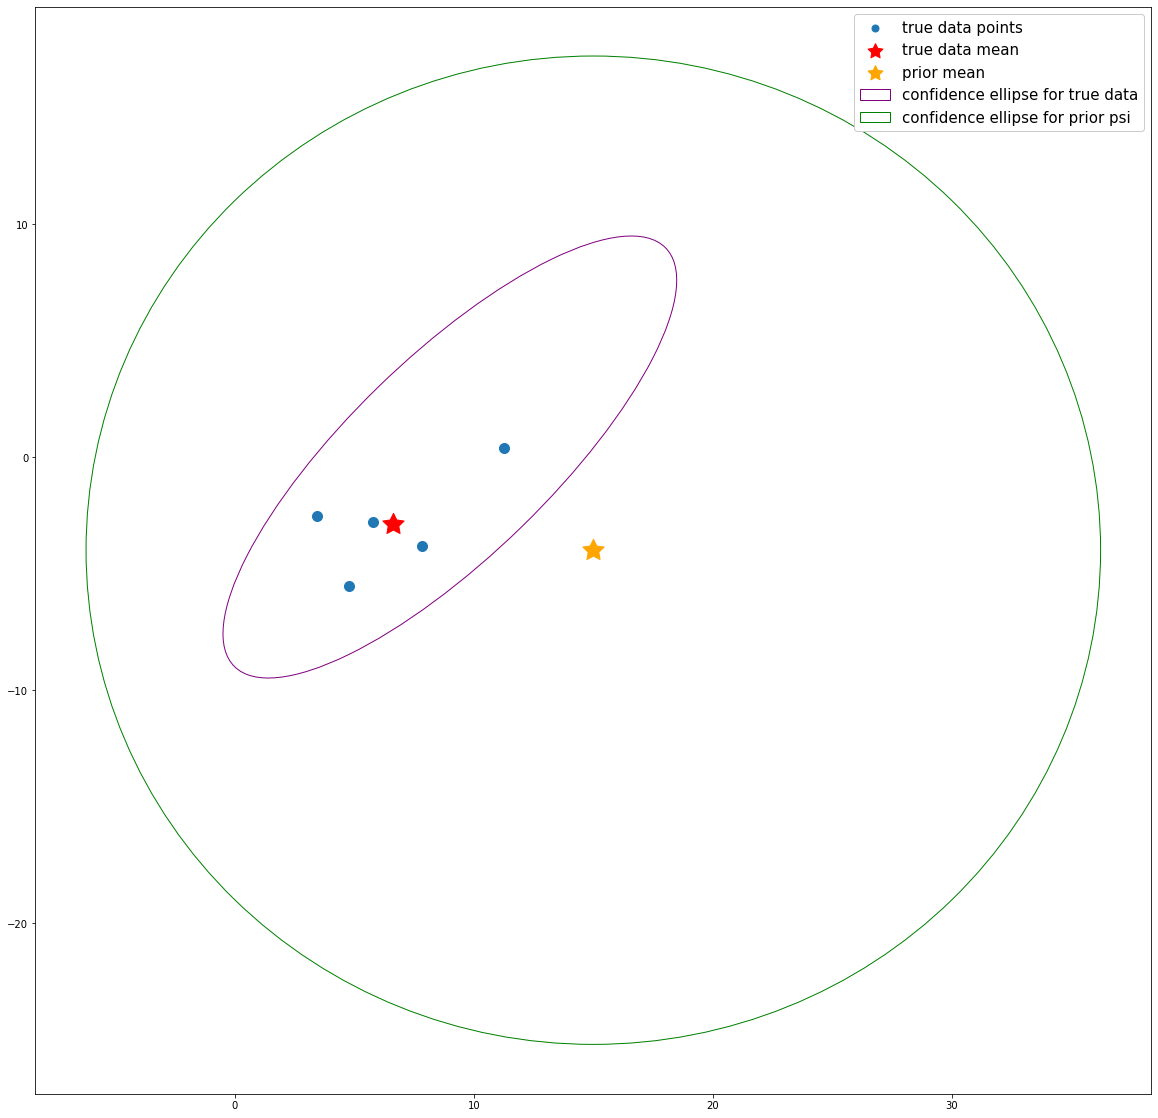

In [4]:
## Generate True Data

prior_mean = np.array([15,-4])

# mu_0_0, sigma_0_0 = 9,2
# mu_1_0, sigma_1_0 = 0,2

mu_0_0, mu_1_0 =  9,0


# X_0 = np.random.normal(mu_0_0, sigma_0_0,500)
# X_1 = np.random.normal(mu_1_0, sigma_1_0,500)


## working psis

## both positvely correlated
# data_psi_0 = np.array([[8, 5], [5, 8]])
# psi_0 = np.array([[50, 20], [20, 50]])


# both negatively correlated
# data_psi_0 = np.array([[8, -5], [-5, 8]])
# psi_0 = np.array([[50, -20], [-20, 50]])

## both uncorrelated
# data_psi_0 = np.array([[8, 0], [0, 8]])
# psi_0 = np.array([[50, 0], [0, 50]])

# true correlated, prior uncorrelated
data_psi_0 = np.array([[10, 8], [8, 10]])
psi_0 = np.array([[50, 0], [0, 50]])



data = pd.DataFrame(np.random.multivariate_normal([mu_0_0,mu_1_0],data_psi_0,5))

data.columns = ['X_0', 'X_1']
X_0 = data['X_0']
X_1 = data['X_1']


# cov = np.cov(X_0,X_1)
mean_params = np.array([mu_0_0,mu_1_0])

#          X_0       X_1
# 0  19.829318 -2.525469
# 1  15.536567 -0.132423
# 2   8.973754 -1.515256
# 3  15.581452  0.308409
# 4  12.837487  1.233319

## skewed data:

#X_0 = np.array([5.922797,6.219637,7.782832,7.224556,2.843914 ])
#X_1 = np.array([0.281539,-0.198847,-1.742269,0.148458,2.009761])

##guassian data

#X_0 = np.array([0.705504,0.45985,-0.259585,-0.225402,-0.080895])
#X_1 = np.array([-0.002918,-0.79659,0.153938,0.590776,-0.431625])

#psi_0 = pd.DataFrame(np.random.multivariate_normal([4,0],np.eye(2)*10,1000))

##X_0 = np.array([-0.355264,0.413329,-0.379939,-0.82394,0.852404])
##X_1 = np.array([-0.287304,0.673887,2.35026,0.693115,0.786935])

# data_dict = {"X_0":X_0, "X_1":X_1}
# data = pd.DataFrame(data_dict)

print(data)
# print(cov)
print(mean_params)
##print(prior_mean[1])
#print(psi_0.iloc[:,1])

mean_data = (np.mean(data, axis = 0))

print(*['prior data mean: (', prior_mean[0],',', prior_mean[1],')'])
print(*['true mean: (', mean_data[0],',',mean_data[1],')'])

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(X_0,X_1,alpha = 1,
            s = 100, label = 'true data points')

ax.scatter(mean_data[0],mean_data[1], marker = (5, 1), s = 500, c = 'red', label = 'true data mean')

ax.scatter(prior_mean[0],prior_mean[1], marker = (5, 1), s = 500, c = 'orange', label = 'prior mean')

#confidence_ellipse(X_0,X_1, ax, label = 'confidence ellipse for true data', edgecolor='purple' )

confidence_ellipse_mean_cov(mean_params, data_psi_0, ax, n_std=3.0, facecolor='none', edgecolor = 'purple'
                            , label = 'confidence ellipse for true data' )

#confidence_ellipse(psi_0.iloc[:,0],psi_0.iloc[:,1], ax, label = 'confidence ellipse for prior psi', edgecolor='green')

confidence_ellipse_mean_cov(prior_mean, psi_0, ax, n_std=3.0, facecolor='none', edgecolor = 'green'
                            , label = 'confidence ellipse for prior psi' )


ax.legend(framealpha=1, frameon=True, markerscale = 0.7, fontsize=15);

plt.show()


In [5]:
params_dict = params_init(data,prior_mean ,psi_0,1)
sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)
print(params_dict)

{'sum_squares': array([37.13553871, 18.76154802]), 'mu_n': array([ 8.0226376 , -3.05217331]), 'kappa_n': 6, 'nu_n': 9, 'psi_n': array([[145.55584199,  10.82555168],
       [ 29.19954237,  69.83959853]])}


In [6]:
model_iter_i = model_iter(data,prior_mean,1,psi_0,1000)

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_i)

mu_s = pd.DataFrame(mu_list)
mu_s.columns = ['mu_0','mu_1']
X_pred = pd.DataFrame(X_list)
X_pred.columns = ['X_0','X_1']
X_pred_mean = np.mean(X_pred, axis = 0)

mu_updated = np.mean(mu_s, axis = 0)
mean_data = (np.mean(data, axis = 0))

sigma_array = np.array(sigma_list)
sigma_array_reshape = sigma_array.reshape(1000,2*2)
sigma_mean_posterior = np.reshape(np.mean(sigma_array_reshape,axis = 0), (2,2))

# print(mu_s)
# print(X_pred)
#print(sigma_list)
#print(sigma_array)
# print(sigma_array_reshape)
# #print(sigma_list)
# print(np.mean(sigma_list))
# print(sigma_array.shape)
# print(sigma_array_reshape.shape)
print(sigma_mean_posterior)
#print((cov))
#print(X_pred_mean)

[[23.59289486  4.63095461]
 [ 4.63095461 11.75260568]]


prior data mean: ( 15 , -4 )
true mean: ( 6.62716511949157 , -2.862607975738988 )
posterior mean: ( 8.033510605996335 , -3.0718340876915216 )


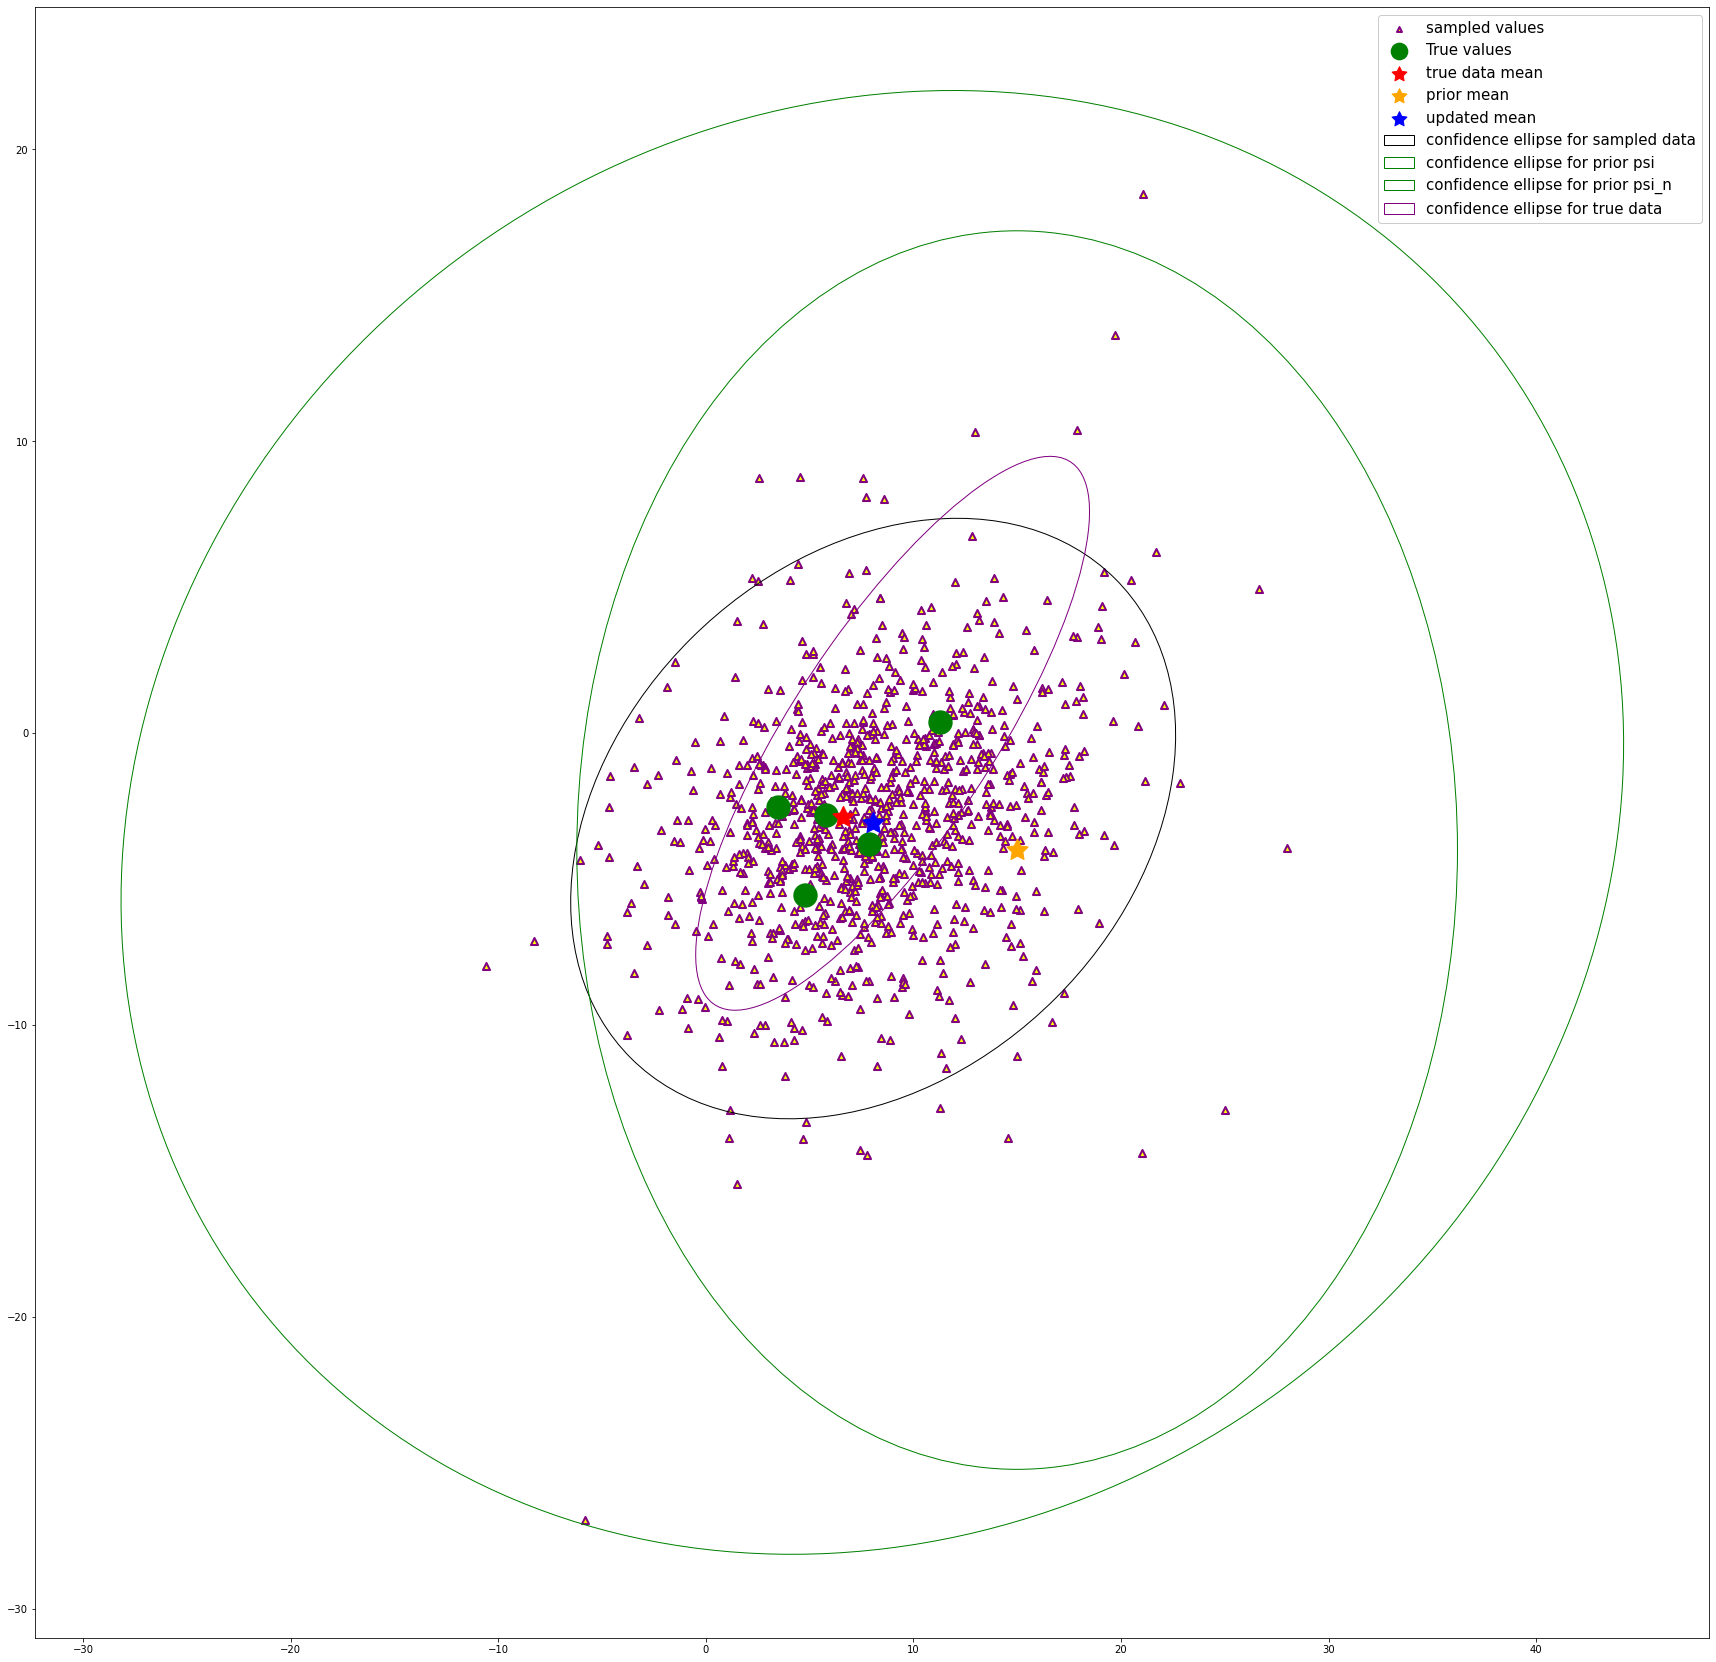

In [7]:
print(*['prior data mean: (', prior_mean[0],',', prior_mean[1],')'])
print(*['true mean: (', mean_data[0],',',mean_data[1],')'])
print(*['posterior mean: (', mu_updated[0],',',mu_updated[1],')'])

fig, ax1 = plt.subplots(figsize=(30, 30))

ax1.scatter(X_pred['X_0'], X_pred['X_1'], c ="yellow",
            linewidths = 2, 
            marker ="^",
            edgecolor ="purple",
            s = 50, label = 'sampled values')

ax1.scatter(X_0, X_1, c ="green",
            linewidths = 2, alpha = 1,
            edgecolor ="green",
            s = 500, label = 'True values')

ax1.scatter(mean_data[0],mean_data[1], marker = (5, 1), s = 500, c = 'red', label = 'true data mean')

ax1.scatter( prior_mean[0], prior_mean[1], marker = (5, 1), s = 500, c = 'orange', label = 'prior mean')

ax1.scatter(mu_updated[0], mu_updated[1], marker = (5, 1), s = 500, c = 'blue', label = 'updated mean')

confidence_ellipse_mean_cov(X_pred_mean, sigma_mean_posterior, ax1, n_std=3.0, facecolor='none', edgecolor = 'black'
                            , label = 'confidence ellipse for sampled data' )

confidence_ellipse_mean_cov(prior_mean, psi_0, ax1, n_std=3.0, facecolor='none', edgecolor = 'green'
                            , label = 'confidence ellipse for prior psi' )

confidence_ellipse_mean_cov(mu_n, psi_n, ax1, n_std=3.0, facecolor='none', edgecolor = 'green'
                            , label = 'confidence ellipse for prior psi_n' )

confidence_ellipse_mean_cov(mean_params, data_psi_0,  ax1, n_std=3.0, facecolor='none', edgecolor = 'purple'
                            , label = 'confidence ellipse for true data' )

ax1.legend(framealpha=1, frameon=True, markerscale = 0.7, fontsize=15);

plt.show()

In [8]:
## Second Model

## true mean:
# mu_11_0, mu_21_0 = -50,100
# mu_12_0, mu_22_0 = -30,20
# mu_13_0, mu_23_0 = 0,-100
# mu_14_0, mu_24_0 = 50,-100
# mu_15_0, mu_25_0 = 100,70



mu_11_0, mu_21_0 = -3,45
mu_12_0, mu_22_0 = -10,20
mu_13_0, mu_23_0 = 15,15
mu_14_0, mu_24_0 = 25,30
mu_15_0, mu_25_0 = 30,40

true_mean_set = np.array([[mu_11_0, mu_21_0],[mu_12_0, mu_22_0]
                          ,[mu_13_0, mu_23_0],[mu_14_0, mu_24_0],[mu_15_0, mu_25_0]])
true_mean_global = np.mean(true_mean_set,axis = 0)


##prior_data

# data_psi_1 = np.array([[100,0],[0,100]])
# data_psi_2 = np.array([[200,0.5],[0.5,200]])
# data_psi_3 = np.array([[150,0],[0,150]])
# data_psi_4 = np.array([[150,-1],[-1,150]])                        
# data_psi_5 = np.array([[300,1.5],[1.5,300]])



data_psi_1 = np.array([[5,0],[0,5]])
data_psi_2 = np.array([[3,0.5],[0.5,3]])
data_psi_3 = np.array([[5,0],[0,5]])
data_psi_4 = np.array([[7,-1],[-1,7]])                        
data_psi_5 = np.array([[2,1.5],[1.5,2]])


# data_psi_1 = np.array([[2,-1],[-1,2]])
# data_psi_2 = np.array([[3,0.5],[0.5,3]])
# data_psi_3 = np.array([[5,2],[2,5]])
# data_psi_4 = np.array([[7,0],[0,7]])                        
# data_psi_5 = np.array([[2,-1],[-1,2]])

data_psis = np.array([data_psi_1,data_psi_2,data_psi_3,data_psi_4,data_psi_5]).reshape(5,4)
data_psis_mean = np.mean(data_psis,axis=0).reshape(2,2)

##prior_mean:
# prior_mu_11_0, prior_mu_21_0 = -55,105
# prior_mu_12_0, prior_mu_22_0 = -35,30
# prior_mu_13_0, prior_mu_23_0 = -5,-110
# prior_mu_14_0, prior_mu_24_0 = 45,-105
# prior_mu_15_0, prior_mu_25_0 = 90,80



prior_mu_11_0, prior_mu_21_0 = -20,60
prior_mu_12_0, prior_mu_22_0 = -8,35
prior_mu_13_0, prior_mu_23_0 = 12,20
prior_mu_14_0, prior_mu_24_0 = 38,45
prior_mu_15_0, prior_mu_25_0 = 40,50

prior_mean_set = np.array([[prior_mu_11_0, prior_mu_21_0],[prior_mu_12_0, prior_mu_22_0]
                          ,[prior_mu_13_0, prior_mu_23_0],[prior_mu_14_0, prior_mu_24_0],[prior_mu_15_0, prior_mu_25_0]])

prior_mean_global = np.mean(prior_mean_set,axis = 0)

print(prior_mean_global)

# ##prior_psi
# prior_psi_1 = np.array([[150,0],[0,150]])
# prior_psi_2 = np.array([[210,0],[0,210]])
# prior_psi_3 = np.array([[155,0],[0,155]])
# prior_psi_4 = np.array([[200,0],[0,200]])
# prior_psi_5 = np.array([[500,0],[0,500]])

prior_psi_1 = np.array([[100,0],[0,100]])
prior_psi_2 = np.array([[80,0],[0,80]])
prior_psi_3 = np.array([[130,0],[0,130]])
prior_psi_4 = np.array([[120,0],[0,120]])
prior_psi_5 = np.array([[100,0],[0,100]])


prior_psis = np.array([prior_psi_1,prior_psi_2,prior_psi_3,prior_psi_4,prior_psi_5]).reshape(5,4)
prior_psis_mean = np.mean(prior_psis,axis=0).reshape(2,2)

## generate data
data_1 = pd.DataFrame(np.random.multivariate_normal([mu_11_0, mu_21_0],data_psi_1,1000))
data_2 = pd.DataFrame(np.random.multivariate_normal([mu_12_0, mu_22_0],data_psi_2,1000))
data_3 = pd.DataFrame(np.random.multivariate_normal([mu_13_0, mu_23_0],data_psi_3,1000))
data_4 = pd.DataFrame(np.random.multivariate_normal([mu_14_0, mu_24_0],data_psi_4,1000))
data_5 = pd.DataFrame(np.random.multivariate_normal([mu_15_0, mu_25_0 ],data_psi_5,1000))

## generate five points:
X_1 = (np.random.multivariate_normal([mu_11_0, mu_21_0],data_psi_1,1))
X_2 = (np.random.multivariate_normal([mu_12_0, mu_22_0],data_psi_2,1))
X_3 = (np.random.multivariate_normal([mu_13_0, mu_23_0],data_psi_3,1))
X_4 = (np.random.multivariate_normal([mu_14_0, mu_24_0],data_psi_4,1))
X_5 = (np.random.multivariate_normal([mu_15_0, mu_25_0 ],data_psi_5,1))

data_model = np.array([X_1,X_2,X_3,X_4,X_5])
data_model = pd.DataFrame(np.array([X_1,X_2,X_3,X_4,X_5]).reshape(5,2))


data_model.columns = ['X_0','X_1']
data_1.columns = ['X_0','X_1']
data_2.columns = ['X_0','X_1']
data_3.columns = ['X_0','X_1']
data_4.columns = ['X_0','X_1']
data_5.columns = ['X_0','X_1']

print(data_model)
print(mean_params)
print(true_mean_global)

[12.4 42. ]
         X_0        X_1
0  -6.144847  48.699247
1  -9.083116  19.021112
2  12.825621  13.703327
3  27.325081  28.068011
4  32.998892  43.318008
[9 0]
[11.4 30. ]


In [9]:
type(np.random.multivariate_normal([mu_11_0, mu_21_0],data_psi_1,1000))

numpy.ndarray

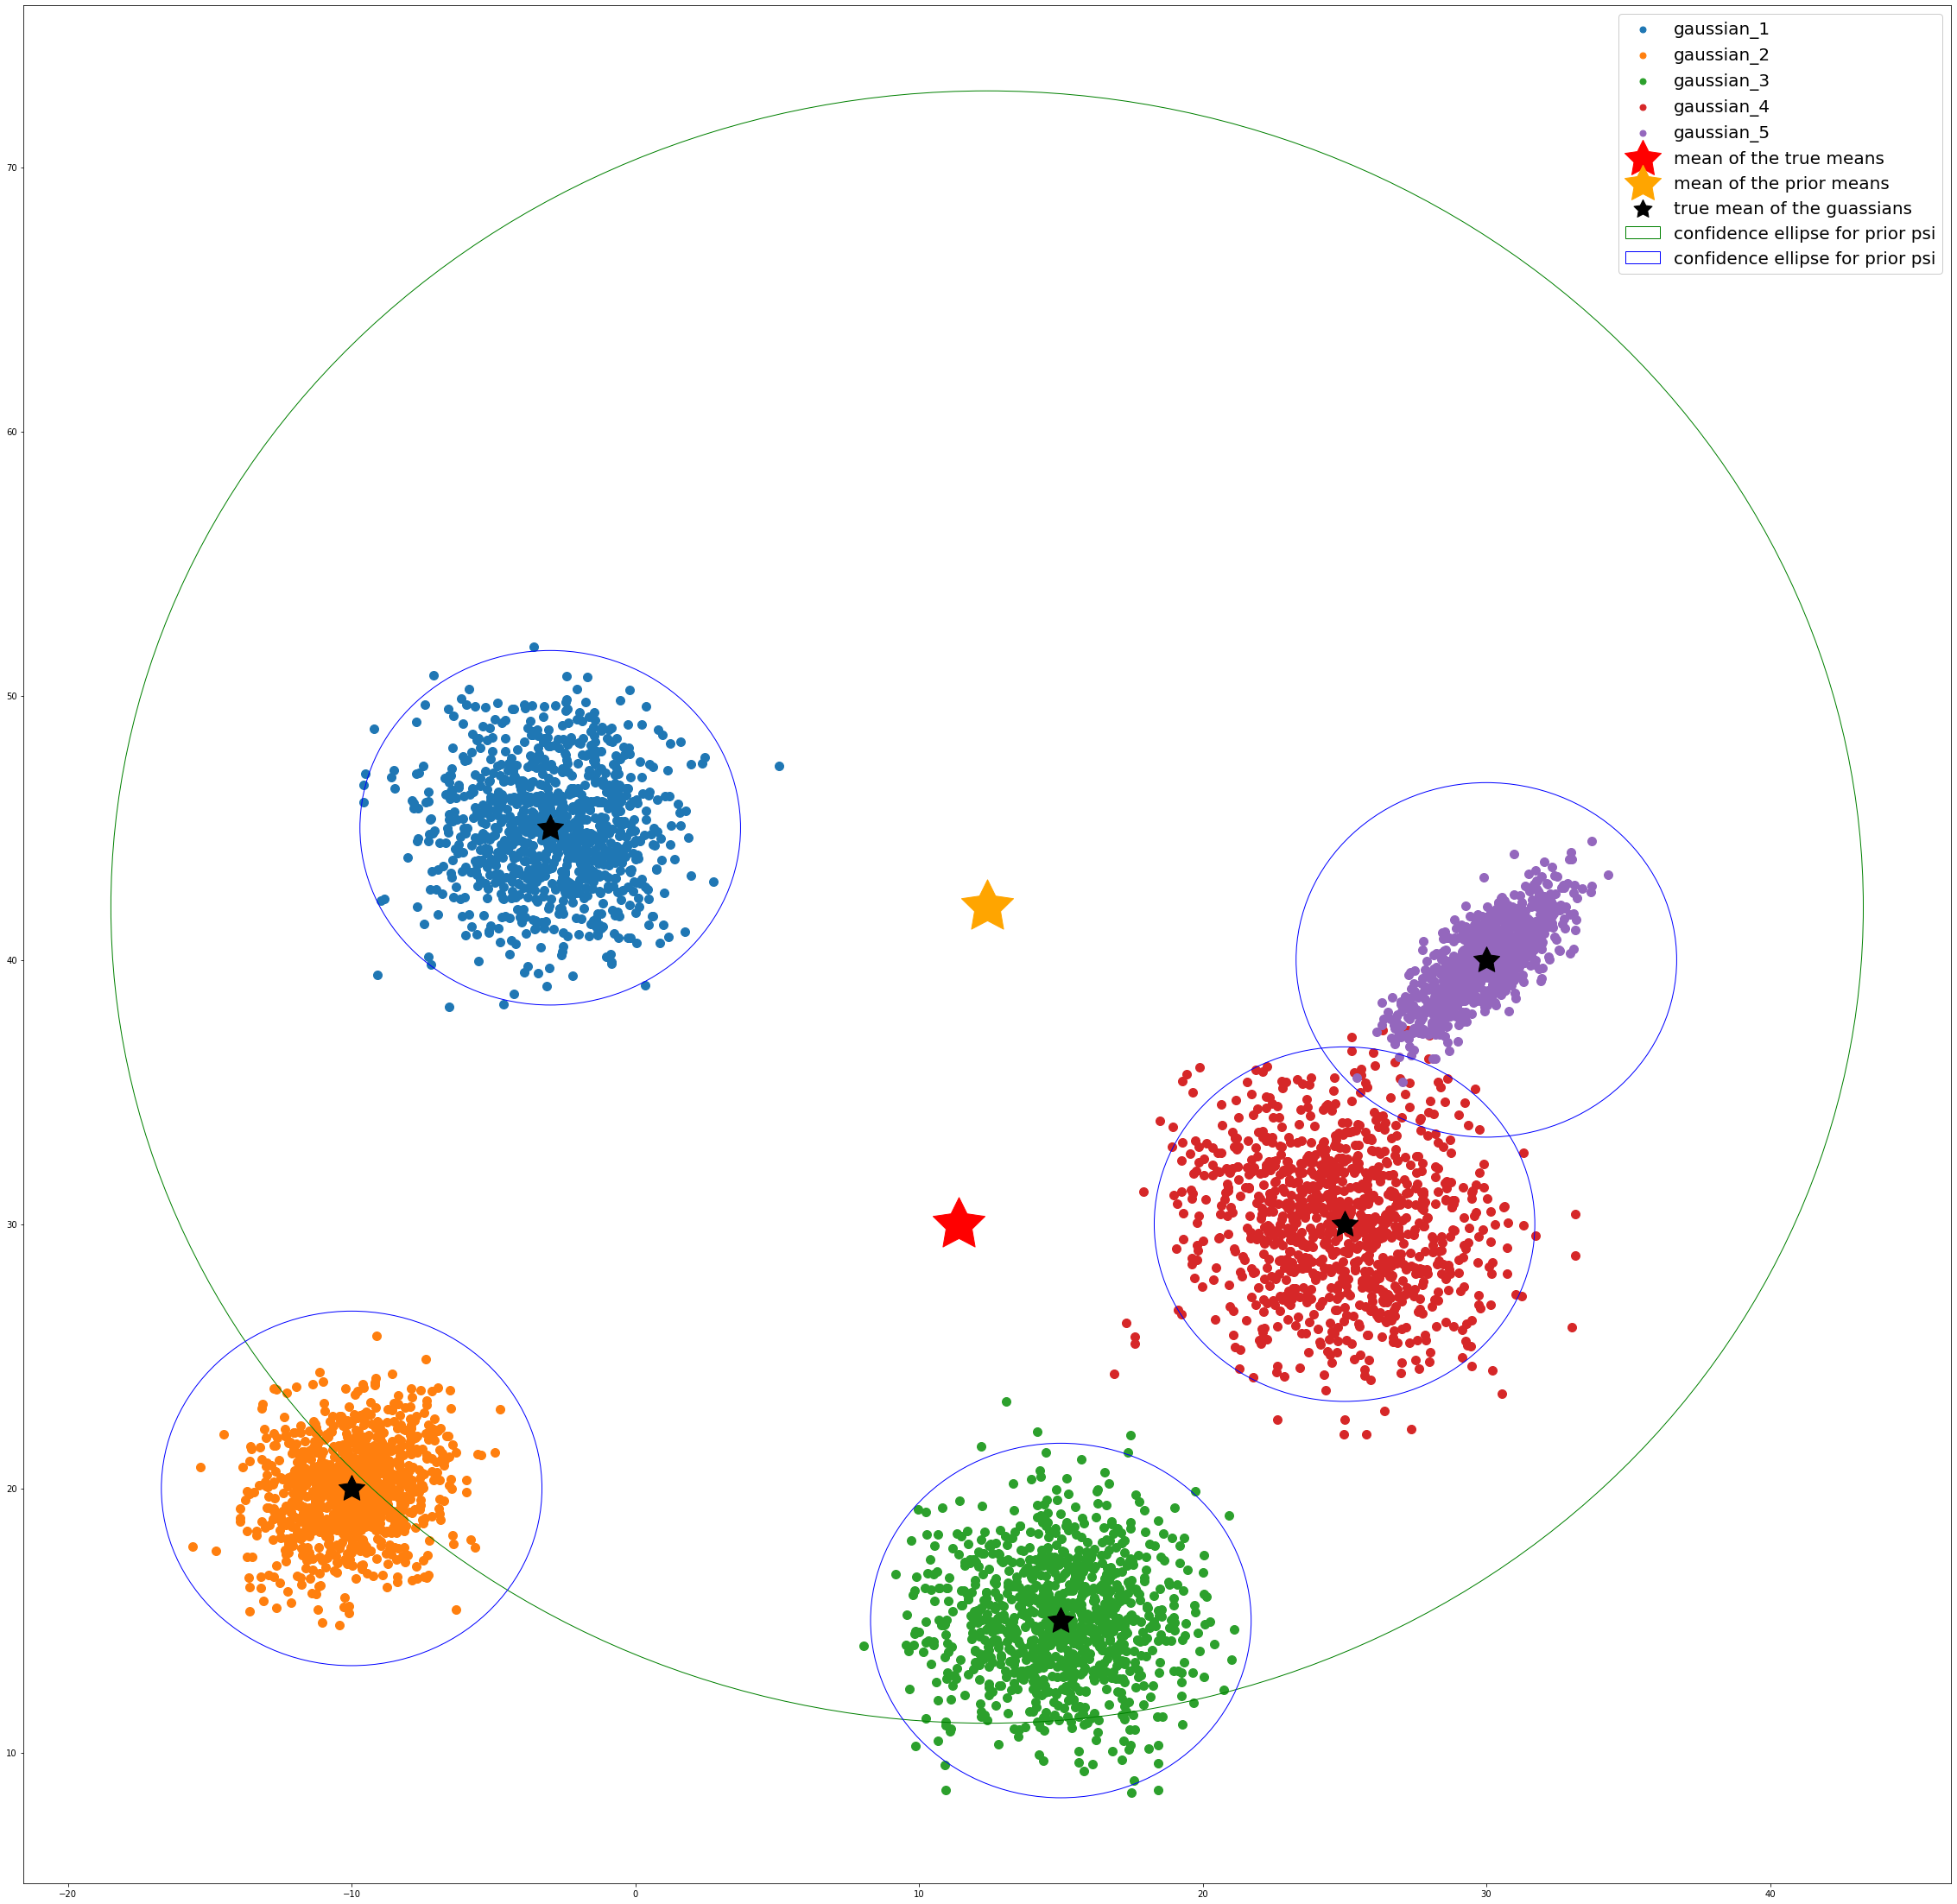

In [10]:
#print(*['prior data mean: (', prior_mean[0],',', prior_mean[1],')'])
#print(*['true mean: (', mean_data[0],',',mean_data[1],')'])

fig, ax2 = plt.subplots(figsize=(40,40))

ax2.scatter(data_1['X_0'],data_1['X_1'] ,alpha = 1,
            s = 100, label = 'gaussian_1')


ax2.scatter(data_2['X_0'],data_2['X_1'],alpha = 1,
            s = 100, label = 'gaussian_2')

ax2.scatter(data_3['X_0'],data_3['X_1'],alpha = 1,
            s = 100, label = 'gaussian_3')

ax2.scatter(data_4['X_0'],data_4['X_1'],alpha = 1,
            s = 100, label = 'gaussian_4')

ax2.scatter(data_5['X_0'],data_5['X_1'],alpha = 1,
            s = 100, label = 'gaussian_5')

# ax2.scatter(X_pred_model_1['X_0'],X_pred_model_1['X_1'],alpha = 0.8,
#              s = 100,label = 'random samples')

# ax2.scatter(X_pred_model_1['X_0'],X_pred_model_1['X_1'],alpha = 1,
#             s = 10, label = 'sample_1')

ax2.scatter(true_mean_global[0],true_mean_global[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the true means', c = 'red')

ax2.scatter(prior_mean_global[0], prior_mean_global[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the prior means', c = 'orange')

ax2.scatter(true_mean_set[:,0], true_mean_set[:,1],alpha = 1,
            s = 1000,marker = (5, 1), label = 'true mean of the guassians', c = 'black')



# confidence_ellipse_mean_cov(true_mean_global, data_psis_mean, ax2, n_std=3.0, facecolor='none', edgecolor = 'purple'
#                             , label = 'confidence ellipse for true data' )

#confidence_ellipse(psi_0.iloc[:,0],psi_0.iloc[:,1], ax, label = 'confidence ellipse for prior psi', edgecolor='green')

confidence_ellipse_mean_cov(prior_mean_global, prior_psis_mean, ax2, n_std=3.0, facecolor='none', edgecolor = 'green'
                            , label = 'confidence ellipse for prior psi' )


# confidence_ellipse_mean_cov([prior_mu_11_0, prior_mu_21_0], prior_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'green'
#                             , label = 'confidence ellipse for prior psi' )

# confidence_ellipse_mean_cov([prior_mu_12_0, prior_mu_22_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')

# confidence_ellipse_mean_cov([prior_mu_13_0, prior_mu_23_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green' )

# confidence_ellipse_mean_cov([prior_mu_14_0, prior_mu_24_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')

# confidence_ellipse_mean_cov([prior_mu_15_0, prior_mu_25_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')


confidence_ellipse_mean_cov([mu_11_0, mu_21_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue'
                            , label = 'confidence ellipse for prior psi' )

confidence_ellipse_mean_cov([mu_12_0, mu_22_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')

confidence_ellipse_mean_cov([mu_13_0, mu_23_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue' )

confidence_ellipse_mean_cov([mu_14_0, mu_24_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')

confidence_ellipse_mean_cov([mu_15_0, mu_25_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')


ax2.legend(framealpha=1, frameon=True, markerscale = 0.7, fontsize=20)

plt.show()

In [11]:
## guassian_1 sampling

def model_2_iter(mu_0,mu_1,data_psi,prior_mean,prior_psi,iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        data = pd.DataFrame(np.random.multivariate_normal([mu_0, mu_1],data_psi,1))
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data,prior_mean,1,prior_psi,10)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1)
        
#         mu_s = pd.DataFrame(mu_list)
#         mu_s.columns = ['mu_0','mu_1']
#         X_pred_model_1 = pd.DataFrame(X_list)
#         X_pred_model_1.columns = ['X_0','X_1']
#         X_pred_mean_model_1 = np.mean(X_pred, axis = 0)
        
#         mu_updated = np.mean(mu_s, axis = 0)
#         mean_data = (np.mean(data, axis = 0))

#         sigma_array = np.array(sigma_list)
#         sigma_array_reshape = sigma_array.reshape(1000,2*2)
#         sigma_mean_posterior = np.reshape(np.mean(sigma_array_reshape,axis = 0), (2,2))
        
        
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})

In [12]:
##model_1
model_1 = model_2_iter(mu_11_0, mu_21_0,data_psi_1,prior_mean_set[0,:],prior_psi_1,100)

In [13]:
##model_2
model_2 = model_2_iter(mu_12_0, mu_22_0,data_psi_2,prior_mean_set[1,:],prior_psi_2,100)

In [14]:
##model_3
model_3 = model_2_iter(mu_13_0, mu_23_0,data_psi_3,prior_mean_set[2,:],prior_psi_3,100)

In [15]:
##model_4
model_4 = model_2_iter(mu_14_0, mu_24_0,data_psi_4,prior_mean_set[3,:],prior_psi_4,100)

In [16]:
##model_5
model_5 = model_2_iter(mu_15_0, mu_25_0,data_psi_5,prior_mean_set[4,:],prior_psi_5,100)

In [17]:
##Model_1 summary

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_1)

mu_s_model_1 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_1.columns = ['mu_0','mu_1']
X_pred_model_1 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_1.columns = ['X_0','X_1']

sigma_array_model_1 = np.array(sigma_list)
sigma_array_reshape_model_1 = sigma_array_model_1.reshape(1000,2*2)
sigma_mean_posterior_model_1 = np.reshape(np.mean(sigma_array_reshape_model_1,axis = 0), (2,2))

In [18]:
##Model_2 summary

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_2)

mu_s_model_2 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_2.columns = ['mu_0','mu_1']
X_pred_model_2 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_2.columns = ['X_0','X_1']

sigma_array_model_2 = np.array(sigma_list)
sigma_array_reshape_model_2 = sigma_array_model_2.reshape(1000,2*2)
sigma_mean_posterior_model_2 = np.reshape(np.mean(sigma_array_reshape_model_2,axis = 0), (2,2))

In [19]:
##Model_3 summary

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_3)

mu_s_model_3 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_3.columns = ['mu_0','mu_1']
X_pred_model_3 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_3.columns = ['X_0','X_1']

sigma_array_model_3 = np.array(sigma_list)
sigma_array_reshape_model_3 = sigma_array_model_3.reshape(1000,2*2)
sigma_mean_posterior_model_3 = np.reshape(np.mean(sigma_array_reshape_model_3,axis = 0), (2,2))

In [20]:
##Model_4 summary

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_4)

mu_s_model_4 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_4.columns = ['mu_0','mu_1']
X_pred_model_4 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_4.columns = ['X_0','X_1']

sigma_array_model_4 = np.array(sigma_list)
sigma_array_reshape_model_4 = sigma_array_model_4.reshape(1000,2*2)
sigma_mean_posterior_model_4 = np.reshape(np.mean(sigma_array_reshape_model_4,axis = 0), (2,2))

In [21]:
##Model_5 summary

mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_5)

mu_s_model_5 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_5.columns = ['mu_0','mu_1']
X_pred_model_5 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_5.columns = ['X_0','X_1']

sigma_array_model_5 = np.array(sigma_list)
sigma_array_reshape_model_5 = sigma_array_model_5.reshape(1000,2*2)
sigma_mean_posterior_model_5 = np.reshape(np.mean(sigma_array_reshape_model_5,axis = 0), (2,2))

In [22]:
## posterior mean and covariance

posterior_mean = pd.concat([mu_s_model_1,mu_s_model_2,mu_s_model_3,mu_s_model_4,mu_s_model_5], axis = 0)
posterior_mean = np.mean(posterior_mean, axis = 0)

posterior_sigma_list = np.array([sigma_mean_posterior_model_1,sigma_mean_posterior_model_2,sigma_mean_posterior_model_3
                       ,sigma_mean_posterior_model_4,sigma_mean_posterior_model_5]).reshape(5,4)

posterior_sigma_mean = np.reshape(np.mean(posterior_sigma_list, axis = 0),(2,2))
# sigma_array_reshape = sigma_array.reshape(1000,2*2)
# sigma_mean_posterior = np.reshape(np.mean(sigma_array_reshape,axis = 0), (2,2))

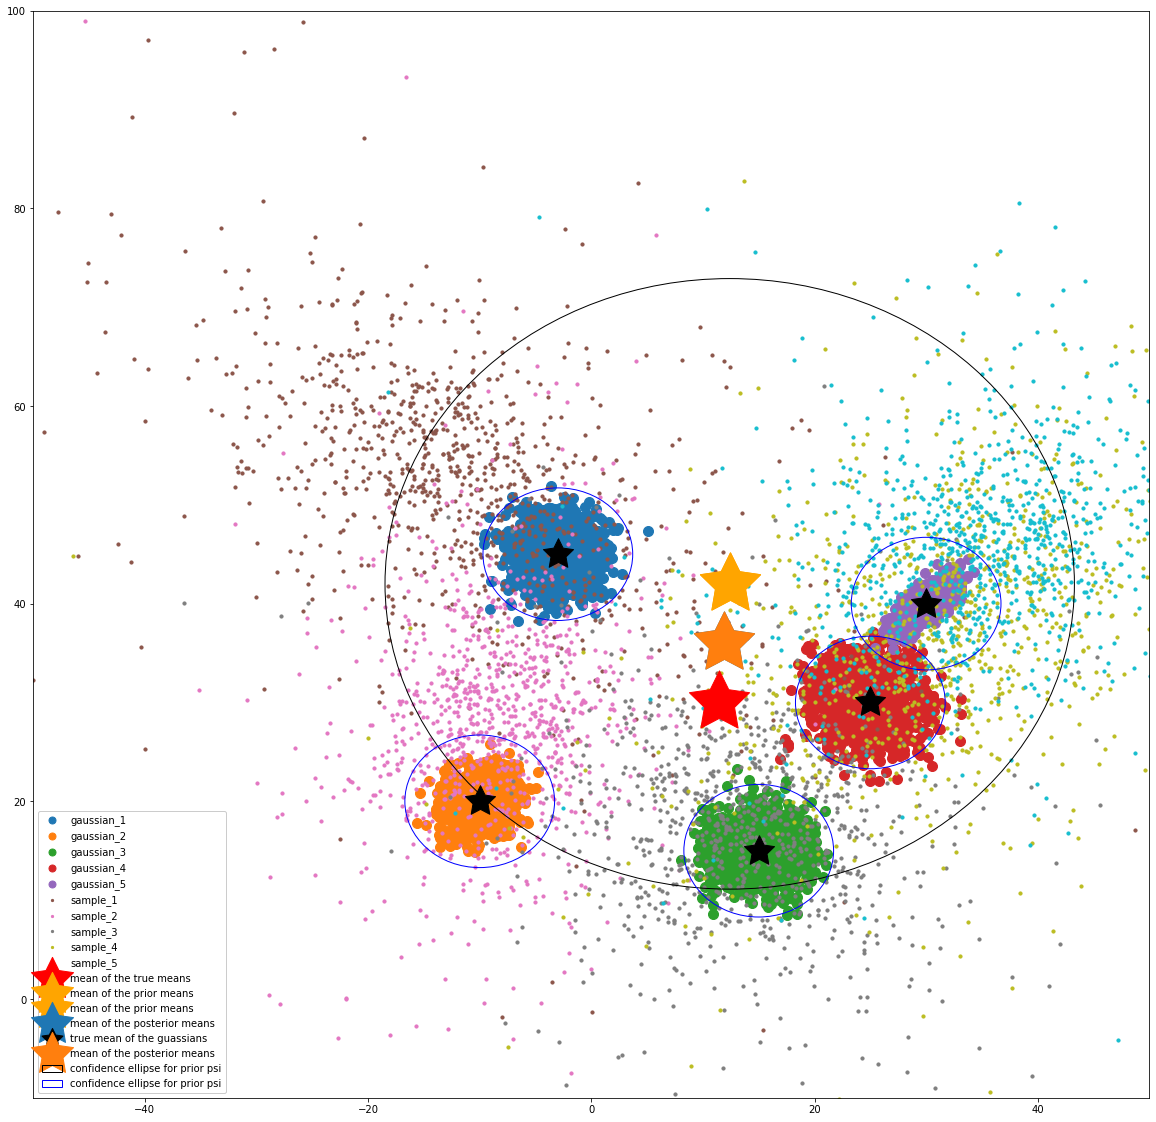

In [27]:
#print(*['prior data mean: (', prior_mean[0],',', prior_mean[1],')'])
#print(*['true mean: (', mean_data[0],',',mean_data[1],')'])

fig, ax2 = plt.subplots(figsize=(20,20))

ax2.scatter(data_1['X_0'],data_1['X_1'] ,alpha = 1,
            s = 100, label = 'gaussian_1')

ax2.scatter(data_2['X_0'],data_2['X_1'],alpha = 1,
            s = 100, label = 'gaussian_2')

ax2.scatter(data_3['X_0'],data_3['X_1'],alpha = 1,
            s = 100, label = 'gaussian_3')

ax2.scatter(data_4['X_0'],data_4['X_1'],alpha = 1,
            s = 100, label = 'gaussian_4')

ax2.scatter(data_5['X_0'],data_5['X_1'],alpha = 1,
            s = 100, label = 'gaussian_5')

# ax2.scatter(X_pred_model_1['X_0'],X_pred_model_1['X_1'],alpha = 0.8,
#              s = 100,label = 'random samples')

ax2.scatter(X_pred_model_1['X_0'],X_pred_model_1['X_1'],alpha = 1,
            s = 10, label = 'sample_1')

ax2.scatter(X_pred_model_2['X_0'],X_pred_model_2['X_1'],alpha = 1,
            s = 10, label = 'sample_2')

ax2.scatter(X_pred_model_3['X_0'],X_pred_model_3['X_1'],alpha = 1,
            s = 10, label = 'sample_3')

ax2.scatter(X_pred_model_4['X_0'],X_pred_model_4['X_1'],alpha = 1,
            s = 10, label = 'sample_4')

ax2.scatter(X_pred_model_5['X_0'],X_pred_model_5['X_1'],alpha = 1,
            s = 10, label = 'sample_5')

ax2.scatter(true_mean_global[0],true_mean_global[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the true means', c = 'red')

ax2.scatter(prior_mean_global[0], prior_mean_global[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the prior means', c = 'orange')

ax2.scatter(prior_mean_global[0], prior_mean_global[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the prior means', c = 'orange')

ax2.scatter(posterior_mean[0], posterior_mean[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the posterior means')



ax2.scatter(true_mean_set[:,0], true_mean_set[:,1],alpha = 1,
            s = 1000,marker = (5, 1), label = 'true mean of the guassians', c = 'black')


ax2.scatter(posterior_mean[0], posterior_mean[1],alpha = 1,
            s = 4000,marker = (5, 1), label = 'mean of the posterior means')




# confidence_ellipse_mean_cov(true_mean_global, data_psis_mean, ax2, n_std=3.0, facecolor='none', edgecolor = 'purple'
#                             , label = 'confidence ellipse for true data' )

#confidence_ellipse(psi_0.iloc[:,0],psi_0.iloc[:,1], ax, label = 'confidence ellipse for prior psi', edgecolor='green')

confidence_ellipse_mean_cov(prior_mean_global, prior_psis_mean, ax2, n_std=3.0, facecolor='none', edgecolor = 'black'
                            , label = 'confidence ellipse for prior psi' )


# confidence_ellipse_mean_cov([prior_mu_11_0, prior_mu_21_0], prior_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'green'
#                             , label = 'confidence ellipse for prior psi' )

# confidence_ellipse_mean_cov([prior_mu_12_0, prior_mu_22_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')

# confidence_ellipse_mean_cov([prior_mu_13_0, prior_mu_23_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green' )

# confidence_ellipse_mean_cov([prior_mu_14_0, prior_mu_24_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')

# confidence_ellipse_mean_cov([prior_mu_15_0, prior_mu_25_0], prior_psi_1,ax2, n_std=3.0, facecolor='none', edgecolor = 'green')


confidence_ellipse_mean_cov([mu_11_0, mu_21_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue'
                            , label = 'confidence ellipse for prior psi' )

confidence_ellipse_mean_cov([mu_12_0, mu_22_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')

confidence_ellipse_mean_cov([mu_13_0, mu_23_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue' )

confidence_ellipse_mean_cov([mu_14_0, mu_24_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')

confidence_ellipse_mean_cov([mu_15_0, mu_25_0], data_psi_1, ax2, n_std=3.0, facecolor='none', edgecolor = 'blue')


ax2.legend(framealpha=1, frameon=True, markerscale = 0.7, fontsize=10)

plt.xlim([-50, 50])
plt.ylim([-10, 100])

plt.show()